<a href="https://colab.research.google.com/github/adem99307/POM/blob/main/POM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install scikit-multilearn
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Next we load the data from csv files into a pandas dataframe and check its attributes.
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/My Drive/train.csv'

data_raw = pd.read_csv(dataset_path)
missing_mask = np.random.choice([False, True], size=data_raw.shape[0]*data_raw.shape[1], p=[0.8, 0.2])
#data_raw.values[missing_mask] = np.nan


print("Number of rows in data =",data_raw.shape[0])

print("Number of columns in data =",data_raw.shape[1])
print("\n")
print("**Sample data:**")
data_raw.head()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of rows in data = 159571
Number of columns in data = 8


**Sample data:**


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


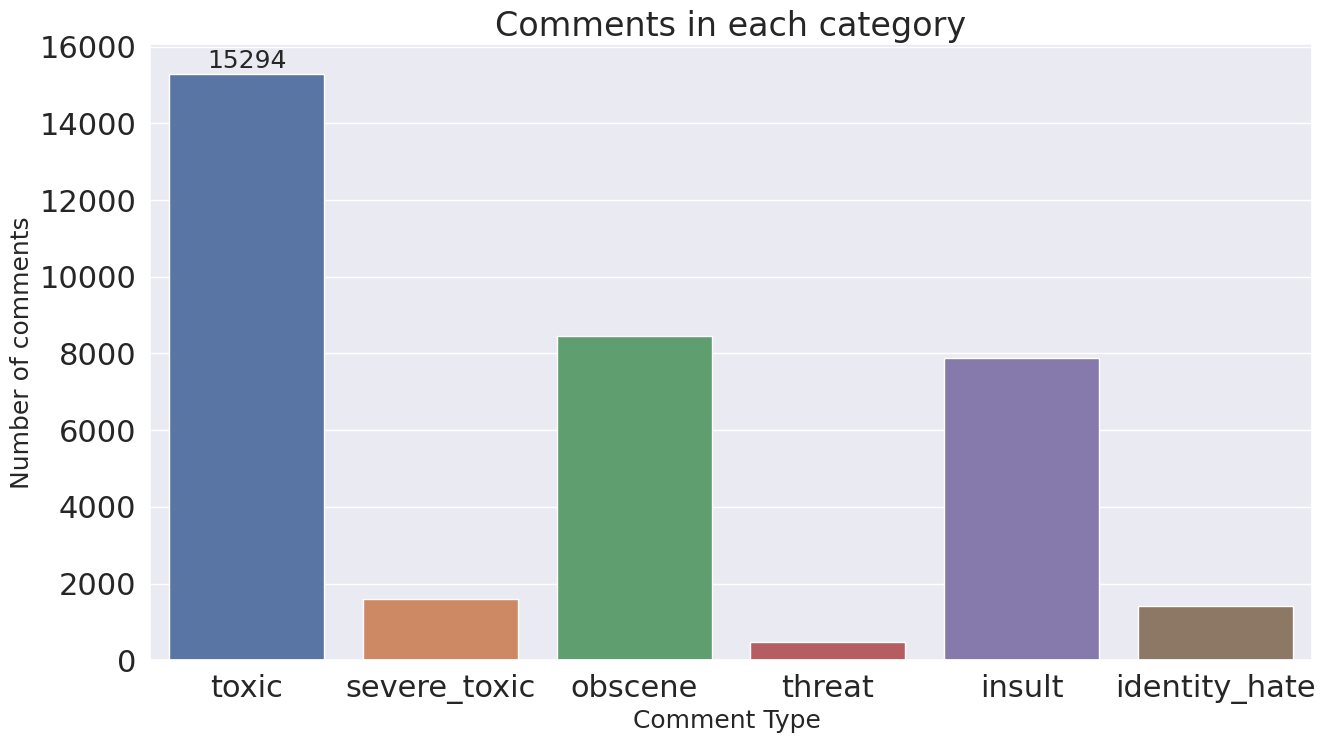

In [6]:
categories = list(data_raw.columns.values)[2:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(x=categories, y=data_raw.iloc[:,2:].sum().values)
plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)#adding the text labels
rects = ax.patches
labels = data_raw.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
    plt.show()

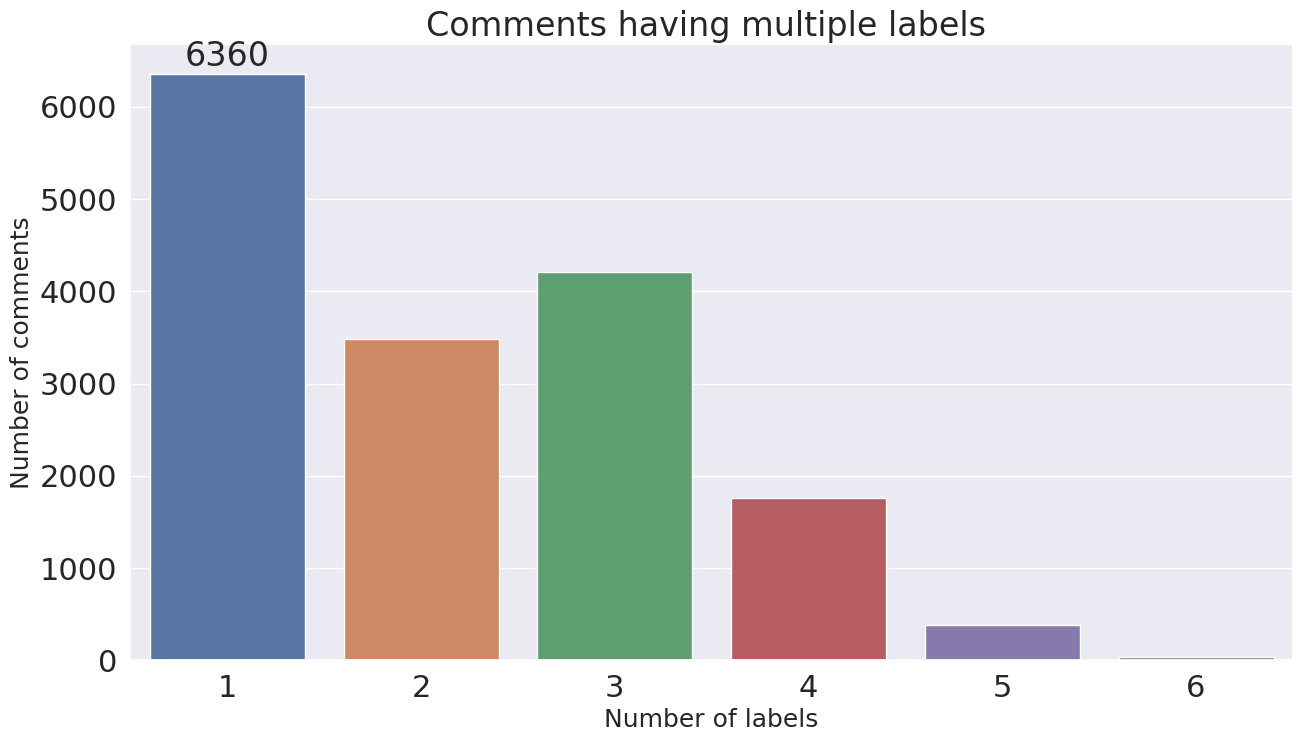

In [7]:
rowSums = data_raw.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(x=multiLabel_counts.index,y=multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    plt.show()

**Data prepocessing**

In [8]:
#Prepocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
data = data_raw
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

data['comment_text'] = data['comment_text'].str.lower()
data['comment_text'] = data['comment_text'].apply(cleanHtml)
data['comment_text'] = data['comment_text'].apply(cleanPunc)
data['comment_text'] = data['comment_text'].apply(keepAlpha)

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
    data['comment_text'] = data['comment_text'].apply(removeStopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
data['comment_text'] = data['comment_text'].apply(stemming)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

#x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.30,shuffle=True)

y_train = train.drop(labels = ['id','comment_text'], axis=1)
y_test = test.drop(labels = ['id','comment_text'], axis=1)



In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# CountVectorizer
cv = CountVectorizer()
X_train = cv.fit_transform(train['comment_text'])
X_test = cv.transform(test['comment_text'])


# TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(train['comment_text'])
X_test_tfidf = tfidf.transform(test['comment_text'])

**Part-5: Multi-Label Classification Techniques:**

**1. OneVsRest**

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train_tfidf, train[category])    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test_tfidf)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

**Processing toxic comments...**
Test accuracy is 0.9588068181818182


**Processing severe_toxic comments...**
Test accuracy is 0.9904954879679144


**Processing obscene comments...**
Test accuracy is 0.9774816176470589


**Processing threat comments...**
Test accuracy is 0.9973470922459893


**Processing insult comments...**
Test accuracy is 0.9706091243315508


**Processing identity_hate comments...**
Test accuracy is 0.9917906082887701




**2. Binary Relevance**

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())# train
classifier.fit(X_train_tfidf, y_train)# predict
predictions = classifier.predict(X_test_tfidf)# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))


**3. Classifier Chains**




In [2]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())# Training logistic regression model on train data
classifier.fit(X_train_tfidf, y_train)# predict
predictions = classifier.predict(X_test_tfidf)# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

NameError: ignored

**4. Label Powerset**

In [ ]:
from skmultilearn.problem_transform import LabelPowerset# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())# train
classifier.fit(X_train_tfidf, y_train)# predict
predictions = classifier.predict(X_test_tfidf)# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

**5. Adapted Algorithm**

In [ ]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
classifier_new = MLkNN(k=10)# Note that this classifier can throw up errors when handling sparse matrices.x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(X_test_tfidf).toarray()# train
classifier_new.fit(X_train_tfidf, y_train)# predict
predictions_new = classifier_new.predict(x_test)# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_new))
print("\n")


In [6]:
!git clone https://github.com/adem99307/POM

!git add .
!git commit -m "COMMIT"
!git push origin main

fatal: destination path 'POM' already exists and is not an empty directory.
/content/POM

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@2d864121c0b2.(none)')
fatal: could not read Username for 'https://github.com': No such device or address
